In [ ]:
#Importing necessary library

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
import PIL
import glob
import pathlib
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import zipfile

zip_path = "/content/drive/MyDrive/Road Signs classification dataset-20250322T134616Z-001.zip"

extract_path = "/content/DATASET"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)
print('Extraction complete!')

Extraction complete!


**PREPROCESSING**

In [ ]:
import os

extract_path = "/content/DATASET/Road Signs classification dataset"
print("Contents of extract_path:", os.listdir(extract_path))


Contents of extract_path: ['labels.csv', 'TEST', 'DATA']


In [ ]:
labels_csv = os.path.join("/content/DATASET/Road Signs classification dataset/labels.csv")
labels_df = pd.read_csv(labels_csv)
print("Labels loaded")

Labels loaded


In [ ]:
data_folder = os.path.join(extract_path, "DATA")
test_folder = os.path.join(extract_path, "TEST")


**Visualize some image from given dataset**

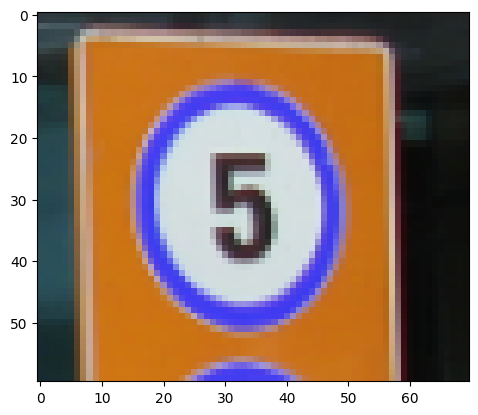

In [ ]:
#Image from train data

import cv2
import matplotlib.pyplot as plt

img = cv2.imread("/content/DATASET/Road Signs classification dataset/DATA/0/000_0034.png")
plt.imshow(img)

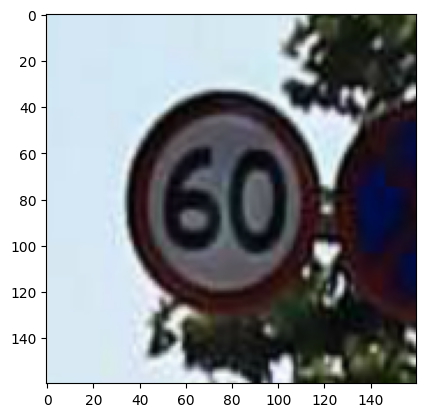

In [ ]:
#Image from test data
img = cv2.imread("/content/DATASET/Road Signs classification dataset/TEST/5/005_0008_j.png")
plt.imshow(img)

In [ ]:
df = labels_df.copy()
df.head()

ClassId                  Name
0        0   Speed limit (5km/h)
1        1  Speed limit (15km/h)
2        2  Speed limit (30km/h)
3        3  Speed limit (40km/h)
4        4  Speed limit (50km/h)

In [ ]:
df.tail()

ClassId                  Name
25       25             keep Left
26       26            keep Right
27       27  Roundabout mandatory
28       28    watch out for cars
29       29                  Horn

In [ ]:
df.describe()

ClassId
count  30.000000
mean   14.500000
std     8.803408
min     0.000000
25%     7.250000
50%    14.500000
75%    21.750000
max    29.000000

In [ ]:
df.dtypes

ClassId     int64
Name       object
dtype: object

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ClassId  30 non-null     int64 
 1   Name     30 non-null     object
dtypes: int64(1), object(1)
memory usage: 612.0+ bytes


In [ ]:
df.duplicated().sum()

np.int64(0)

**Load dataset**

In [ ]:
# Define parameters
batch_size = 32
image_height = 64
image_width = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_folder,shuffle = True,
															image_size=(
																image_height, image_width),
															seed=123,
															batch_size=32,validation_split=False)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_folder,shuffle = False,
															image_size=(
																image_height, image_width),
															seed=123,
															batch_size=32, validation_split=False)


Found 743 files belonging to 30 classes.
Found 743 files belonging to 30 classes.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_folder,
    shuffle = False,image_size=(image_height, image_width),
															seed=123,
															batch_size=32, validation_split=False)

Found 285 files belonging to 30 classes.


In [ ]:
# Get class names
class_names = train_ds.class_names
classes_num = len(class_names)
print(f"Number of classes: {classes_num}, Class Names: {class_names}")


Number of classes: 30, Class Names: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '4', '5', '6', '7', '8', '9']


**List out all the classes which correspond to the directory names in alphabetical order.**

In [ ]:

# Convert to dictionary: {0: "Speed limit (5km/h)", 1: "Speed limit (15km/h)", ...}
class_mapping = dict(zip(labels_df["ClassId"], labels_df["Name"]))

# Update class names
class_names = [class_mapping[int(cls)] for cls in class_names]

print(f"Mapped Class Names: {class_names}")


Mapped Class Names: ['Speed limit (5km/h)', 'Speed limit (15km/h)', 'Dont Go straight', 'Dont Go Left', 'Dont Go Left or Right', 'Dont Go Right', 'Dont overtake from Left', 'No Uturn', 'No Car', 'No horn', 'No entry', 'No stopping', 'Speed limit (30km/h)', 'Go straight or right', 'Go straight', 'Go Left', 'Go Left or right', 'Go Right', 'keep Left', 'keep Right', 'Roundabout mandatory', 'watch out for cars', 'Horn', 'Speed limit (40km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'speed limit (80km/h)', 'Dont Go straight or left', 'Unknown7']


In [ ]:
train_ds.class_names

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

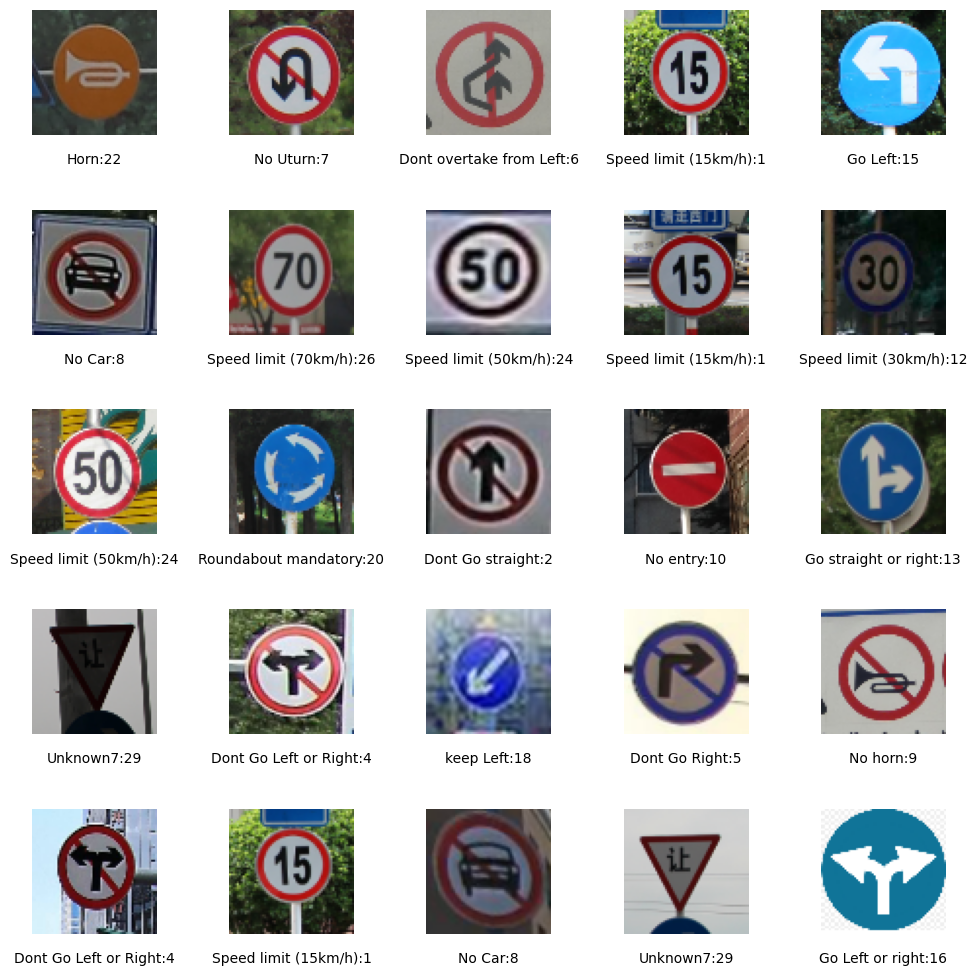

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import tensorflow as tf

# Visualize images with class names and labels
plt.figure(figsize=(12, 12))  # Increase figure size

for images, labels in train_ds.take(1):  # Load one batch of images and labels
    images = images.numpy()  # Convert Tensor to NumPy array
    labels = labels.numpy()  # Convert labels to NumPy array

    for i in range(min(25, images.shape[0])):  # Show up to 25 images
        ax = plt.subplot(5, 5, i + 1)  # Arrange images in 5x5 grid
        plt.imshow(images[i].astype("uint8"))  # Ensure correct dtype for display
        plt.title(f"{class_names[labels[i]]}:{labels[i]}", fontsize=10, y=-0.3)  # Adjust font size and position
        plt.axis("off")  # Remove axes

# Adjust layout to add more space between images
plt.subplots_adjust(hspace=0.6, wspace=0.4)  # Increase spacing between plots
plt.show()


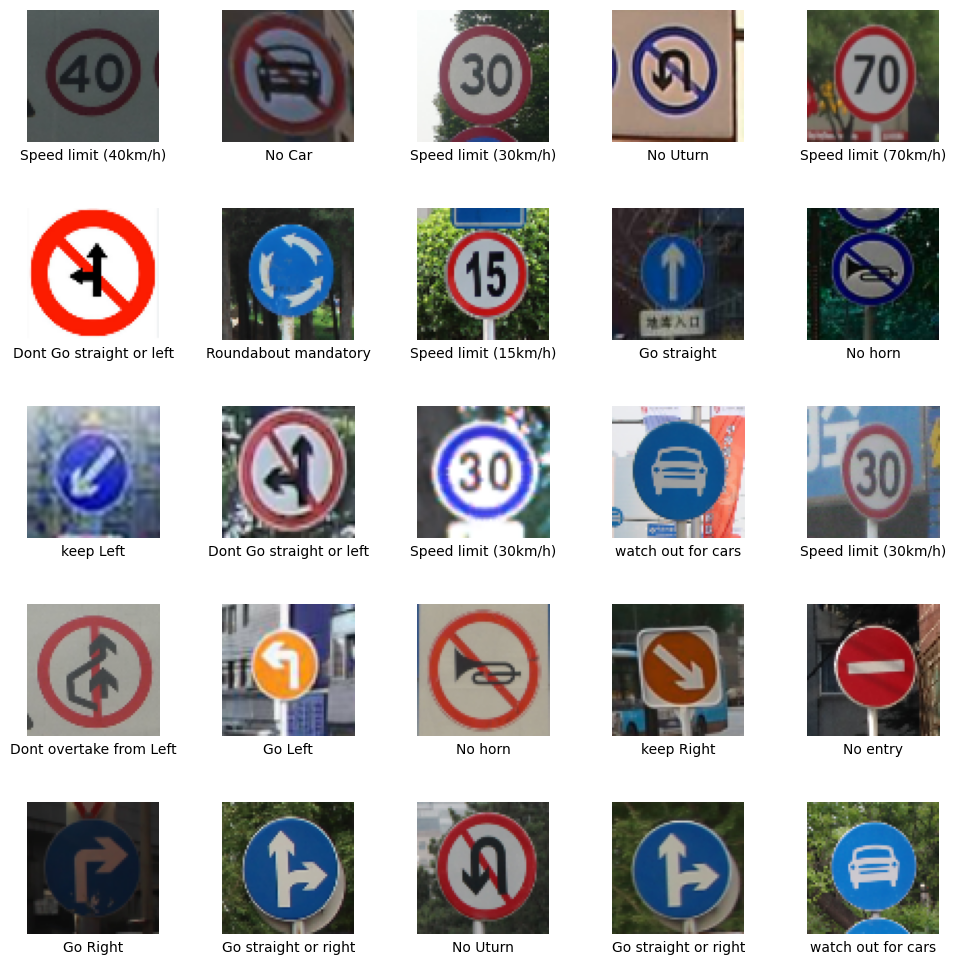

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import tensorflow as tf

# Visualize images
plt.figure(figsize=(12, 12))  # Increase figure size

for images, labels in train_ds.take(1):
    images = images.numpy()  # Convert Tensor to NumPy
    labels = labels.numpy()

    for i in range(min(25, images.shape[0])):  # Show up to 25 images
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].astype("uint8"))  # Ensure correct dtype
        plt.title(class_names[labels[i]], fontsize=10, y=-0.2)  # Adjust font size and position
        plt.axis("off")

plt.subplots_adjust(hspace=0.5, wspace=0.3)  # Add space between plots
plt.show()


Class Names: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '4', '5', '6', '7', '8', '9']


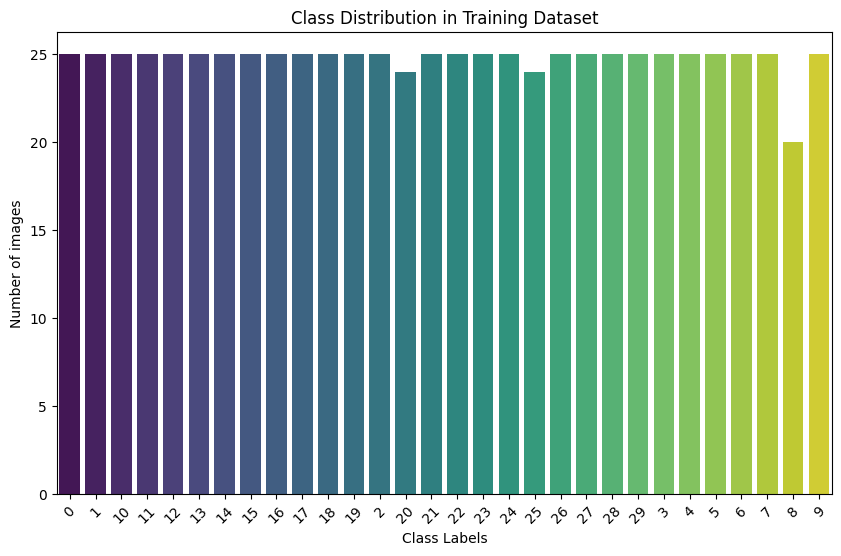

In [ ]:

# Get class names (i.e., folder names in the dataset)
class_names = train_ds.class_names
print(f"Class Names: {class_names}")

# Count the number of samples for each class
class_counts = {class_name: 0 for class_name in class_names}

# Iterate through the dataset and count each label's occurrences
for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[class_names[label]] += 1

# Plot the distribution of class labels
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='viridis')
plt.title("Class Distribution in Training Dataset")
plt.xlabel("Class Labels")
plt.ylabel("Number of images")
plt.xticks(rotation=45)
plt.show()


**MODEL BUILDING**

In [ ]:
# Create the CNN model
model = tf.keras.Sequential([
    layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),

    # 1st Convolution Layer
    layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),

    # 2nd Convolution Layer
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),

    # 3rd Convolution Layer
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),

    layers.Flatten(),  # Flatten the 2D outputs to 1D

    # Fully Connected Layer 1
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),  # Dropout for regularization

    # Fully Connected Layer 2
    layers.Dense(128, activation='relu'),

    # Output Layer
    layers.Dense(classes_num, activation='softmax')  # 'softmax' for multi-class classification
])





In [ ]:
model.compile(
    optimizer='adam',  # Optimizer
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Loss function for multi-class classification
    metrics=['accuracy']  # Evaluation metric
)


In [ ]:
# Summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 30)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 568,382 (2.17 MB)

 Trainable params: 568,382 (2.17 MB)

 Non-trainable params: 0 (0.00 B)

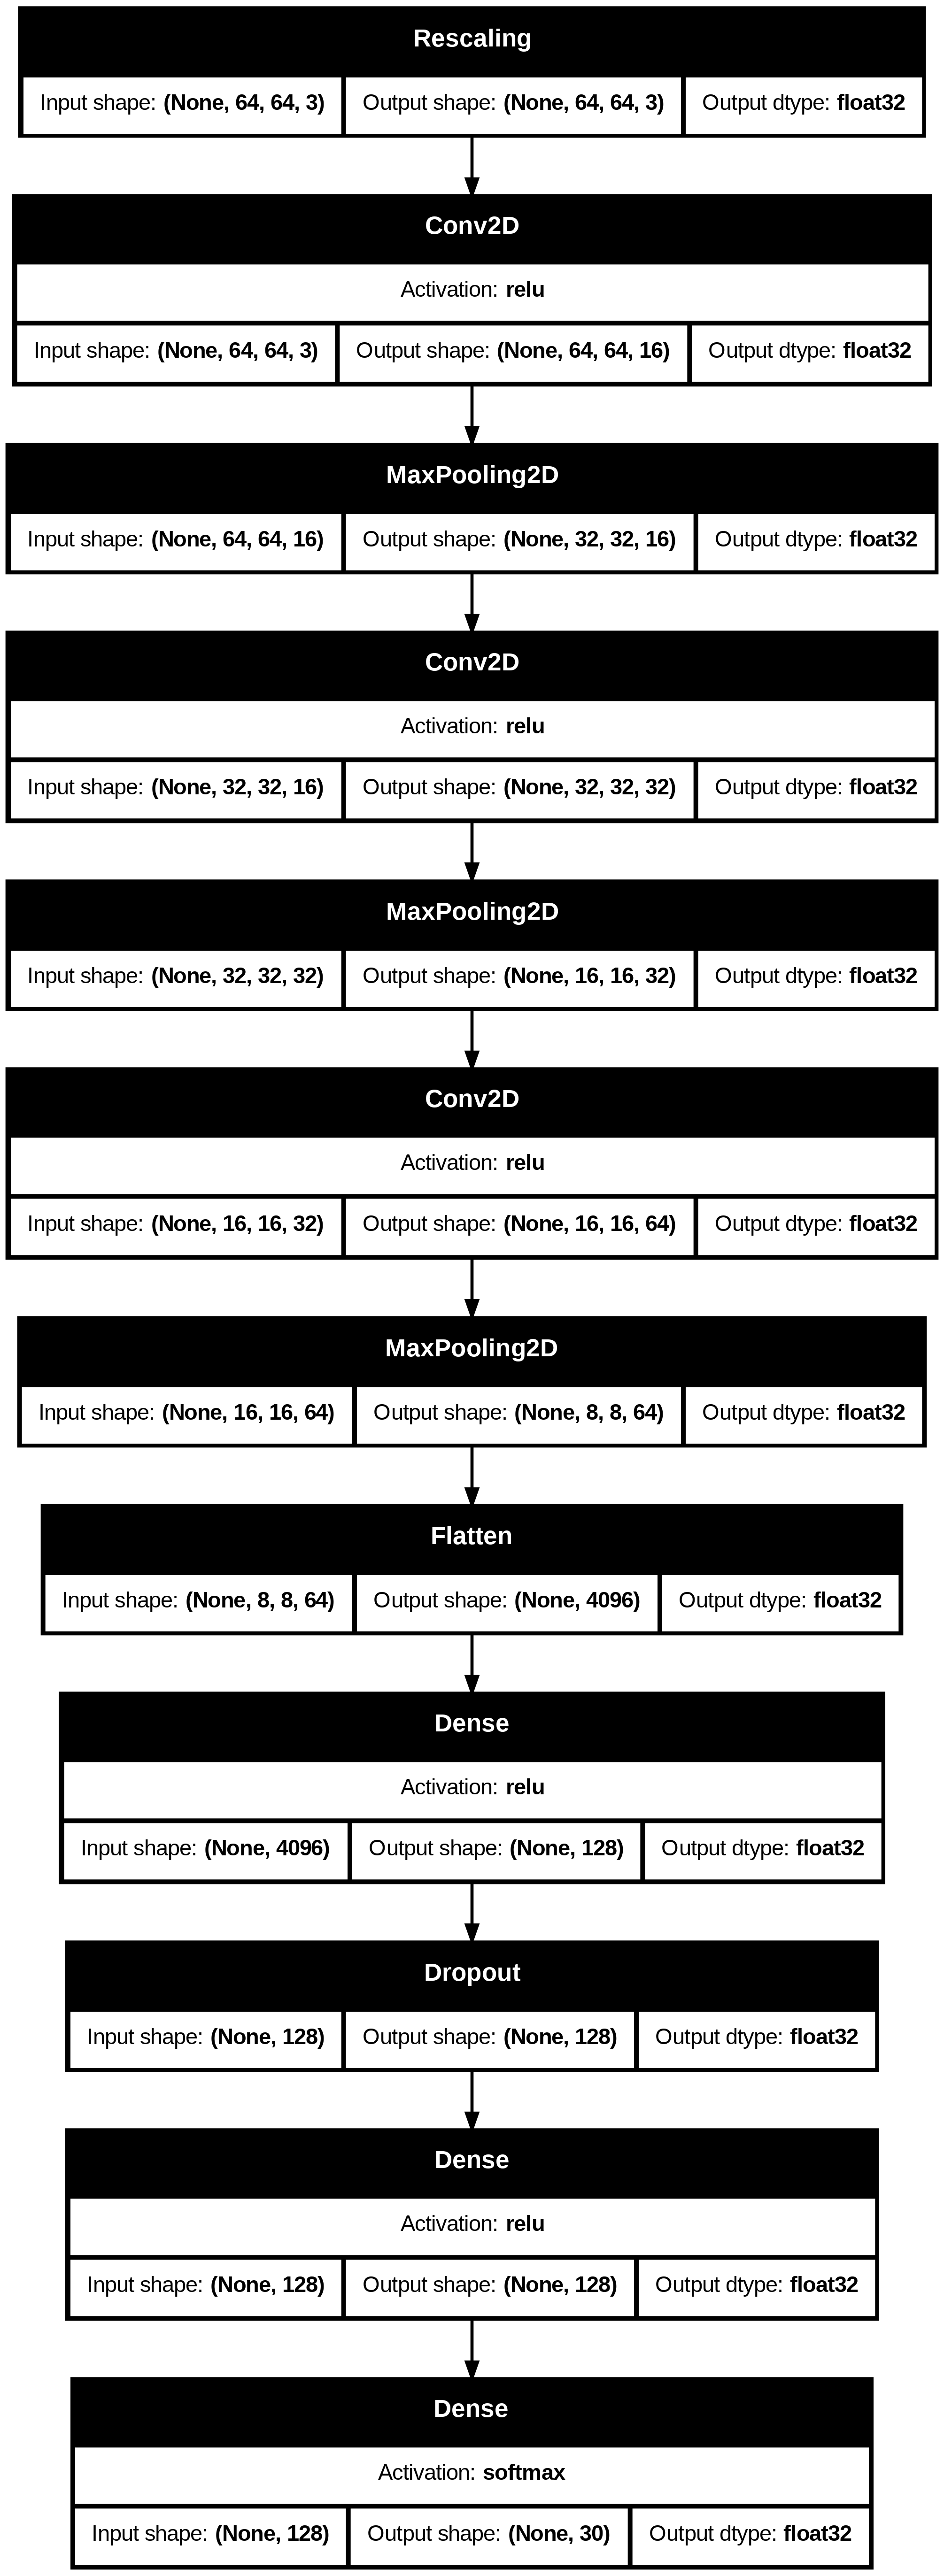

In [ ]:
from tensorflow import keras

keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations=True,
    dpi=240,  # Reduce image size (increase value for smaller image)
    expand_nested=False  # Keep nested layers compact
)


In [ ]:
# Train the model for 20 epochs

epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 316ms/step - accuracy: 0.0244 - loss: 3.4134 - val_accuracy: 0.0821 - val_loss: 3.3352
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - accuracy: 0.0953 - loss: 3.2718 - val_accuracy: 0.1763 - val_loss: 2.8934
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - accuracy: 0.1990 - loss: 2.8407 - val_accuracy: 0.3728 - val_loss: 2.4474
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 235ms/step - accuracy: 0.2990 - loss: 2.4570 - val_accuracy: 0.4872 - val_loss: 1.8845
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 268ms/step - accuracy: 0.4244 - loss: 1.9566 - val_accuracy: 0.6703 - val_loss: 1.3674
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 260ms/step - accuracy: 0.5912 - loss: 1.4959 - val_accuracy: 0.7954 - val_loss: 0.8931
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 236ms/step - accuracy: 0.6656 - loss: 1.1296 - val_accuracy: 0.8304 - val_loss: 0.6285
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 237ms/step - accuracy: 0.7396 - loss: 0.8881 - val_accur

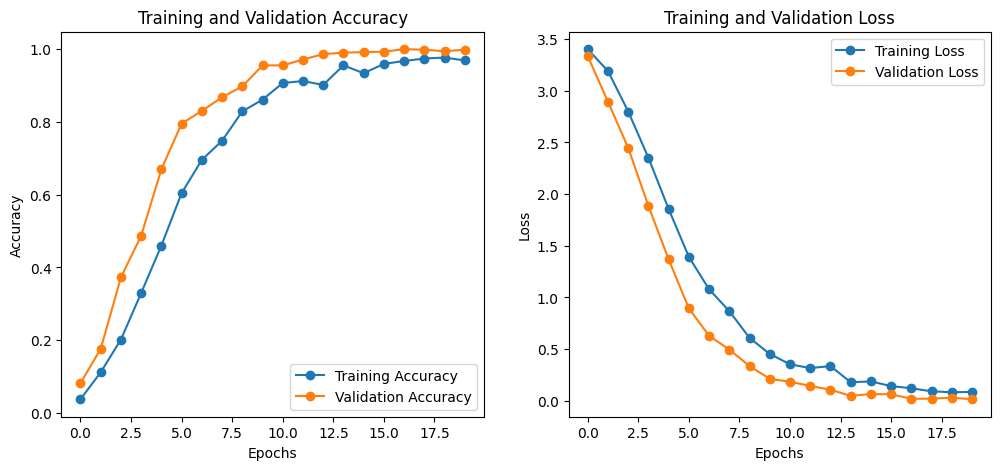

In [ ]:
import matplotlib.pyplot as plt

# Extract history safely (handling missing keys)
acc = history.history.get('accuracy', [])
val_acc = history.history.get('val_accuracy', [])
loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])

# Get the actual number of trained epochs
epochs_trained = len(acc)  # This ensures correct plotting range
epochs_range = range(epochs_trained)

# Visualization
plt.figure(figsize=(12, 5))

# Training & Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")

# Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")

plt.show()


**INFERENCES**

*As eppoch increases training and validation accuracy both increases to nearly 1

*This model has perfect training accuracy (0.9632) and validation accuracy
(0.9973), that means no overfitting which requires no tuning.

*Training loss decreases by increasing epoch at the same time, validation loss reduces to certain limit.


**Next step Approach**

*Try prediction on trained data.

*Trained the model on test data to check whether the taffic image are predicted correctly or not


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


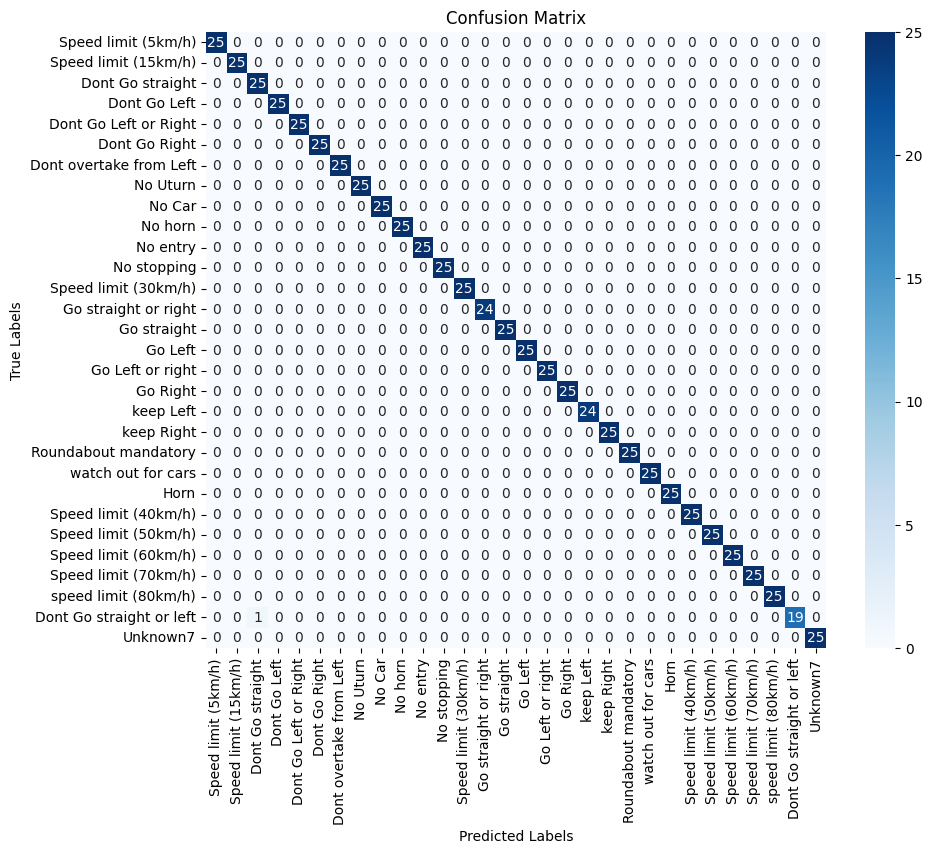

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get true labels and predictions
true_labels = []
predictions = []

for images, labels in val_ds:
    true_labels.extend(labels.numpy())  # Append true labels
    preds = model.predict(images)  # Predict the images
    predictions.extend(np.argmax(preds, axis=1))  # Convert softmax probabilities to predicted class indices

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)

# Plot the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()




**Model Performance on trained data**

In [ ]:
# Classification Report
report = classification_report(true_labels, predictions, target_names=class_names)
print(report)

                          precision    recall  f1-score   support

     Speed limit (5km/h)       1.00      1.00      1.00        25
    Speed limit (15km/h)       1.00      1.00      1.00        25
        Dont Go straight       0.96      1.00      0.98        25
            Dont Go Left       1.00      1.00      1.00        25
   Dont Go Left or Right       1.00      1.00      1.00        25
           Dont Go Right       1.00      1.00      1.00        25
 Dont overtake from Left       1.00      1.00      1.00        25
                No Uturn       1.00      1.00      1.00        25
                  No Car       1.00      1.00      1.00        25
                 No horn       1.00      1.00      1.00        25
                No entry       1.00      1.00      1.00        25
             No stopping       1.00      1.00      1.00        25
    Speed limit (30km/h)       1.00      1.00      1.00        25
    Go straight or right       1.00      1.00      1.00        24
         

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Class type of an image is Speed limit (5km/h) with accuracy of 8.57


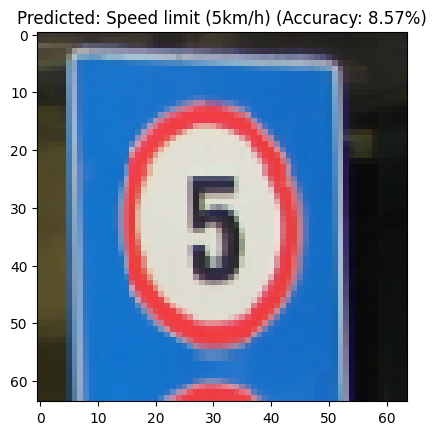

In [ ]:
#Trying to predict the class of image
image = '/content/DATASET/Road Signs classification dataset/DATA/0/000_0034.png'
image = tf.keras.utils.load_img(image, target_size=(image_height,image_width))
img_arr = tf.keras.utils.array_to_img(image)
img_bat=tf.expand_dims(img_arr,0)
predict = model.predict(img_bat)
predict = model.predict(img_bat)
score = tf.nn.softmax(predict)

#Displaying the class name, accuracy and also the corresponding image
print('Class type of an image is {} with accuracy of {:0.2f}'.format(class_names[np.argmax(score)],np.max(score)*100))
plt.imshow(image, cmap='gray')
plt.title('Predicted: {} (Accuracy: {:0.2f}%)'.format(class_names[np.argmax(score)], np.max(score) * 100))
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Class type of an image is Dont Go Right with accuracy of 8.57


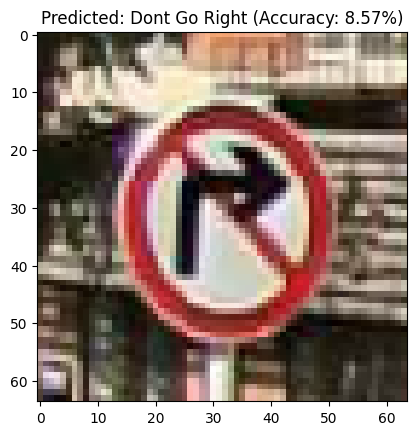

In [ ]:
#Trying to predict the class of image
image = '/content/DATASET/Road Signs classification dataset/DATA/13/013_0022_j.png'
image = tf.keras.utils.load_img(image, target_size=(image_height,image_width))
img_arr = tf.keras.utils.array_to_img(image)
img_bat=tf.expand_dims(img_arr,0)
predict = model.predict(img_bat)
predict = model.predict(img_bat)
score = tf.nn.softmax(predict)

#Displaying the class name, accuracy and also the corresponding image
print('Class type of an image is {} with accuracy of {:0.2f}'.format(class_names[np.argmax(score)],np.max(score)*100))
plt.imshow(image, cmap='gray')
plt.title('Predicted: {} (Accuracy: {:0.2f}%)'.format(class_names[np.argmax(score)], np.max(score) * 100))
plt.show()

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


**MODEL EVALUATION AND TESTING ON TEST DATA**

In [ ]:

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import tensorflow as tf


# Get true labels and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())  # Convert Tensor to list
    preds = model.predict(images)  # Get predictions
    y_pred.extend(np.argmax(preds, axis=1))  # Convert probabilities to class index

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


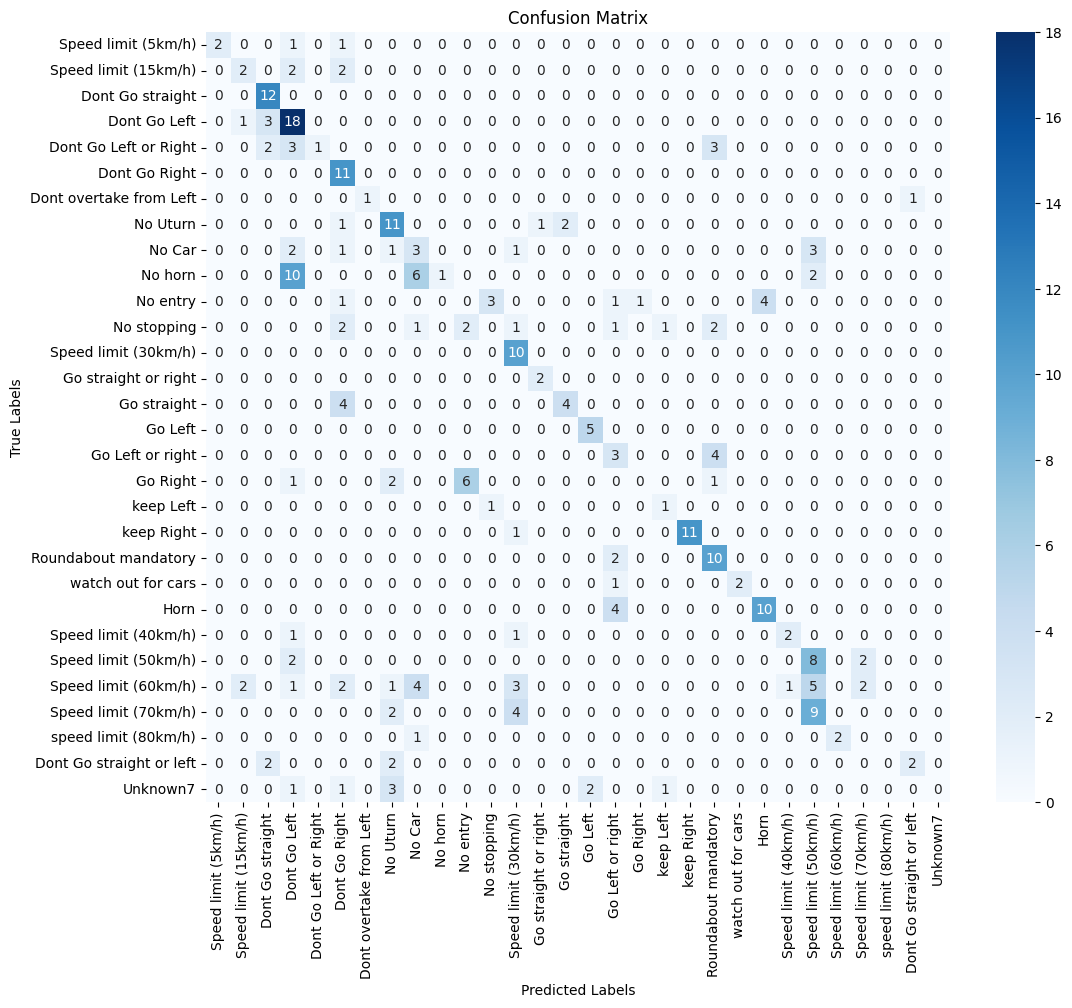

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [ ]:
# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Accuracy: 0.9987
Precision: 0.9987
Recall: 0.9987
F1-Score: 0.9987


In [ ]:
# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
                          precision    recall  f1-score   support

     Speed limit (5km/h)       1.00      0.50      0.67         4
    Speed limit (15km/h)       0.40      0.33      0.36         6
        Dont Go straight       0.63      1.00      0.77        12
            Dont Go Left       0.43      0.82      0.56        22
   Dont Go Left or Right       1.00      0.11      0.20         9
           Dont Go Right       0.42      1.00      0.59        11
 Dont overtake from Left       1.00      0.50      0.67         2
                No Uturn       0.50      0.73      0.59        15
                  No Car       0.20      0.27      0.23        11
                 No horn       1.00      0.05      0.10        19
                No entry       0.00      0.00      0.00        10
             No stopping       0.00      0.00      0.00        10
    Speed limit (30km/h)       0.48      1.00      0.65        10
    Go straight or right       0.67      1.00      0

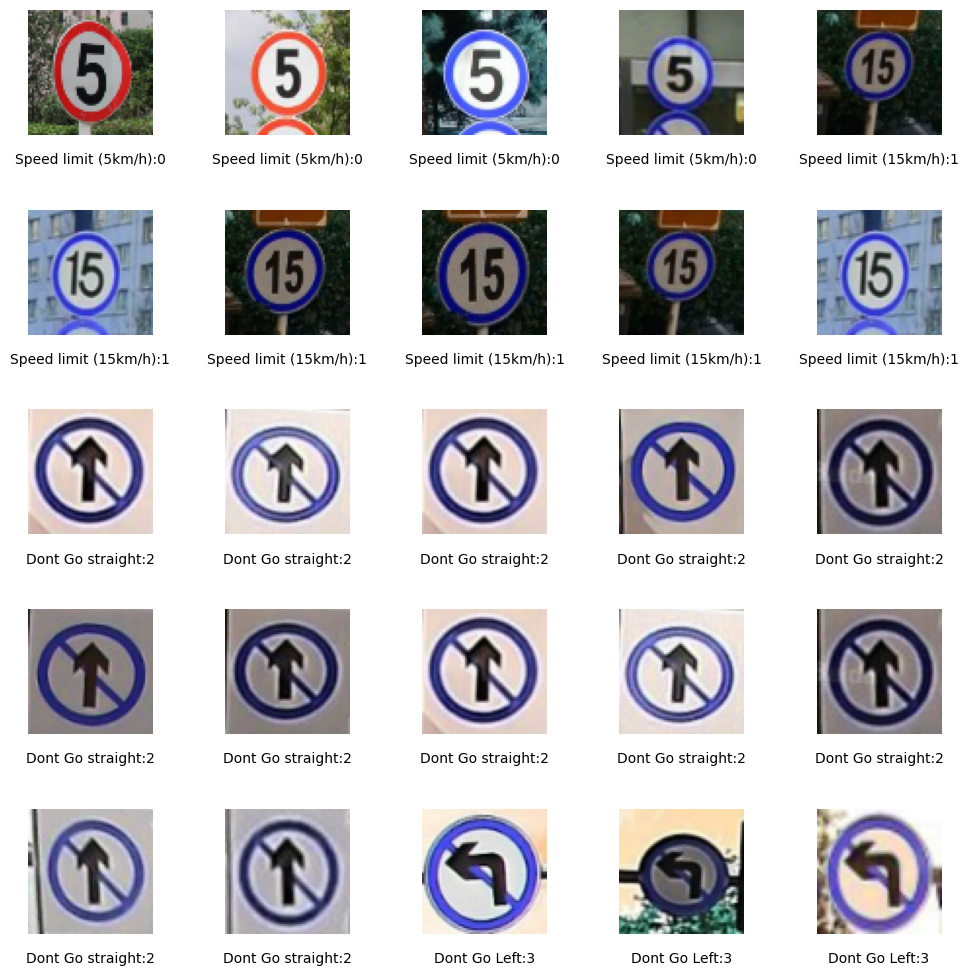

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import tensorflow as tf

# Visualize images with class names and labels
plt.figure(figsize=(12, 12))  # Increase figure size

for images, labels in test_ds.take(1):  # Load one batch of images and labels
    images = images.numpy()  # Convert Tensor to NumPy array
    labels = labels.numpy()  # Convert labels to NumPy array

    for i in range(min(25, images.shape[0])):  # Show up to 25 images
        ax = plt.subplot(5, 5, i + 1)  # Arrange images in 5x5 grid
        plt.imshow(images[i].astype("uint8"))  # Ensure correct dtype for display
        plt.title(f"{class_names[labels[i]]}:{labels[i]}", fontsize=10, y=-0.3)  # Adjust font size and position
        plt.axis("off")  # Remove axes

# Adjust layout to add more space between images
plt.subplots_adjust(hspace=0.6, wspace=0.4)  # Increase spacing between plots
plt.show()


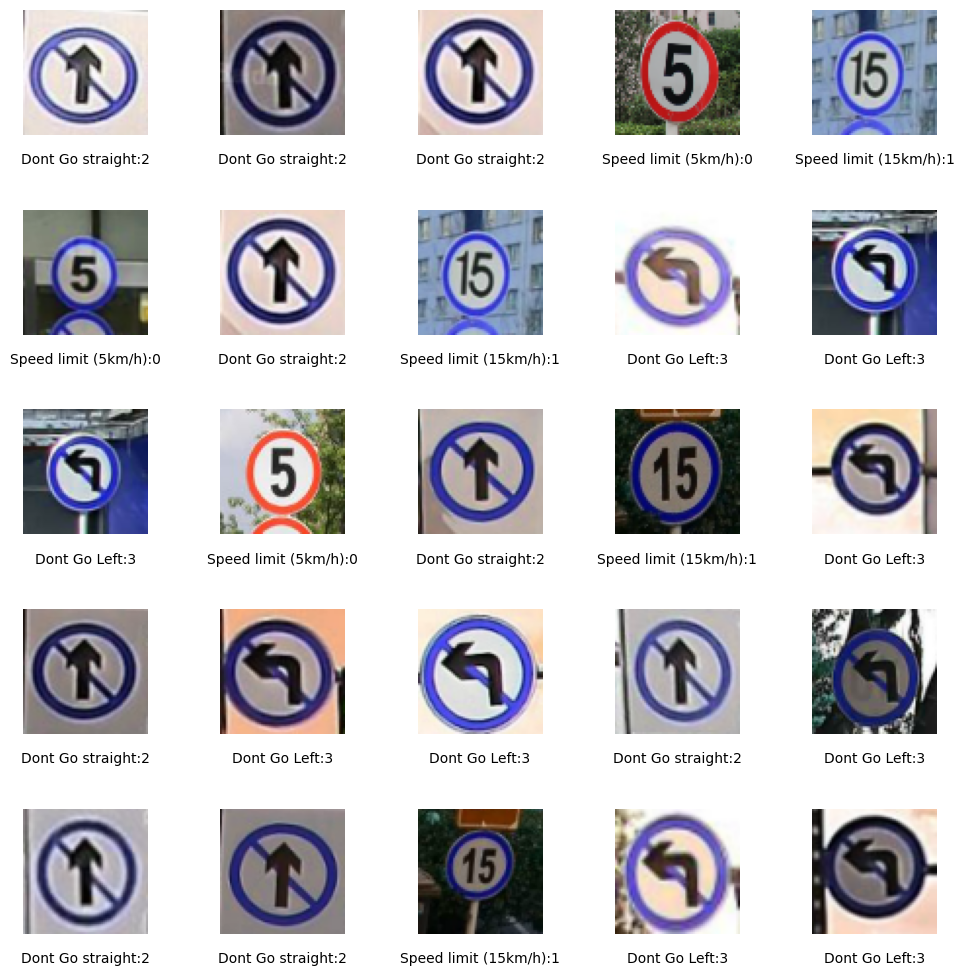

In [ ]:
# Visualize random images with class names and labels
import random
plt.figure(figsize=(12, 12))  # Increase figure size

for images, labels in test_ds.take(1):  # Load one batch of images and labels
    images = images.numpy()  # Convert Tensor to NumPy array
    labels = labels.numpy()  # Convert labels to NumPy array
    indices = random.sample(range(images.shape[0]), min(25, images.shape[0]))  # Select random indices

    for i, idx in enumerate(indices):  # Show up to 25 random images
        ax = plt.subplot(5, 5, i + 1)  # Arrange images in 5x5 grid
        plt.imshow(images[idx].astype("uint8"))  # Ensure correct dtype for display
        plt.title(f"{class_names[labels[idx]]}:{labels[idx]}", fontsize=10, y=-0.3)  # Adjust font size and position
        plt.axis("off")  # Remove axes

# Adjust layout to add more space between images
plt.subplots_adjust(hspace=0.6, wspace=0.4)  # Increase spacing between plots
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Class type of an image is Roundabout mandatory with accuracy of 8.54


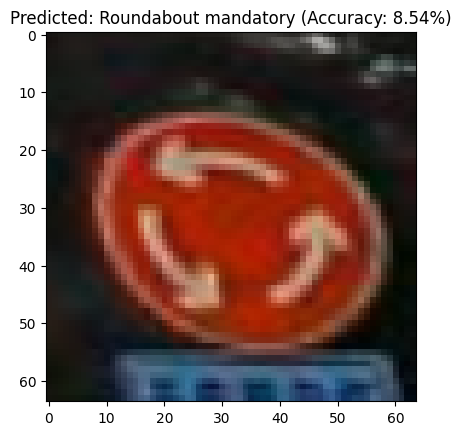

In [ ]:
#Trying to predict the class of image
image = '/content/DATASET/Road Signs classification dataset/TEST/27/027_0002_j.png'
image = tf.keras.utils.load_img(image, target_size=(image_height,image_width))
img_arr = tf.keras.utils.array_to_img(image)
img_bat=tf.expand_dims(img_arr,0)
predict = model.predict(img_bat)
predict = model.predict(img_bat)
score = tf.nn.softmax(predict)

#Displaying the class name, accuracy and also the corresponding image
print('Class type of an image is {} with accuracy of {:0.2f}'.format(class_names[np.argmax(score)],np.max(score)*100))
plt.imshow(image, cmap='gray')
plt.title('Predicted: {} (Accuracy: {:0.2f}%)'.format(class_names[np.argmax(score)], np.max(score) * 100))
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Class type of an image is Speed limit (30km/h) with accuracy of 8.55


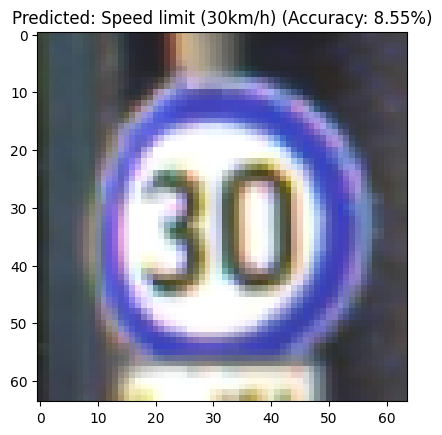

In [ ]:
#Trying to predict the class of image
image = '/content/DATASET/Road Signs classification dataset/TEST/2/002_0017.png'
image = tf.keras.utils.load_img(image, target_size=(image_height,image_width))
img_arr = tf.keras.utils.array_to_img(image)
img_bat=tf.expand_dims(img_arr,0)
predict = model.predict(img_bat)
predict = model.predict(img_bat)
score = tf.nn.softmax(predict)

#Displaying the class name, accuracy and also the corresponding image
print('Class type of an image is {} with accuracy of {:0.2f}'.format(class_names[np.argmax(score)],np.max(score)*100))
plt.imshow(image, cmap='gray')
plt.title('Predicted: {} (Accuracy: {:0.2f}%)'.format(class_names[np.argmax(score)], np.max(score) * 100))
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Class type of an image is Dont Go Left with accuracy of 8.50


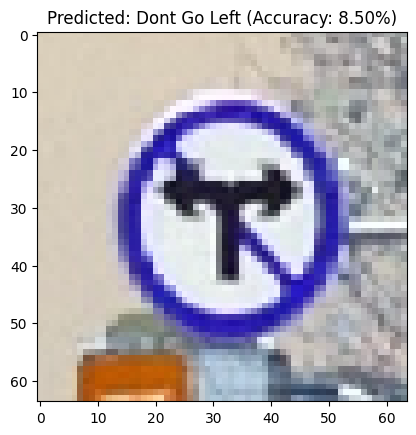

In [ ]:
#Trying to predict the class of image
image = '/content/DATASET/Road Signs classification dataset/TEST/12/012_0008_j.png'
image = tf.keras.utils.load_img(image, target_size=(image_height,image_width))
img_arr = tf.keras.utils.array_to_img(image)
img_bat=tf.expand_dims(img_arr,0)
predict = model.predict(img_bat)
predict = model.predict(img_bat)
score = tf.nn.softmax(predict)

#Displaying the class name, accuracy and also the corresponding image
print('Class type of an image is {} with accuracy of {:0.2f}'.format(class_names[np.argmax(score)],np.max(score)*100))
plt.imshow(image, cmap='gray')
plt.title('Predicted: {} (Accuracy: {:0.2f}%)'.format(class_names[np.argmax(score)], np.max(score) * 100))
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Class type of an image is Dont Go straight with accuracy of 8.57


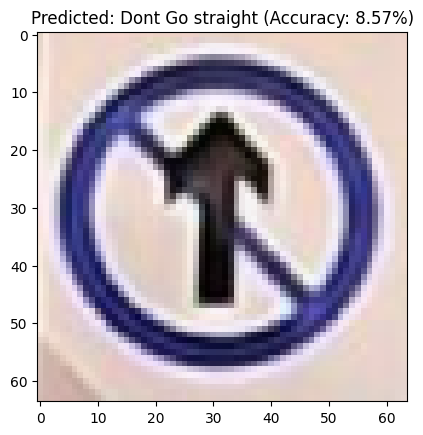

In [ ]:
#Trying to predict the class of image
image = '/content/DATASET/Road Signs classification dataset/TEST/10/010_0012_j.png'
image = tf.keras.utils.load_img(image, target_size=(image_height,image_width))
img_arr = tf.keras.utils.array_to_img(image)
img_bat=tf.expand_dims(img_arr,0)
predict = model.predict(img_bat)
predict = model.predict(img_bat)
score = tf.nn.softmax(predict)

#Displaying the class name, accuracy and also the corresponding image
print('Class type of an image is {} with accuracy of {:0.2f}'.format(class_names[np.argmax(score)],np.max(score)*100))
plt.imshow(image, cmap='gray')
plt.title('Predicted: {} (Accuracy: {:0.2f}%)'.format(class_names[np.argmax(score)], np.max(score) * 100))
plt.show()

**SAVING BEST MODEL**

In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.0 MB/s eta 0:00:00


In [ ]:
!pip install pyngrok

In [ ]:
!pip install streamlit pyngrok -q

In [ ]:
import streamlit as st
import tensorflow as tf
from tensorflow import keras
from PIL import Image


model.save("best_model.keras")


In [ ]:
#Load the saved model


from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("best_model.keras")


**Streamlit UI**

In [ ]:
%%writefile app.py


st.title("Roadside Sign Classification")
st.write("Upload an image to classify the roadside sign.")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "png", "jpeg"])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption="Uploaded Image", use_column_width=True)

    if st.button("Classify Sign"):
        predicted_label, confidence = predict(image)
        st.write(f"### Predicted Class: {predicted_label}")
        st.write(f"### Confidence Score: {confidence:.2f}")

# Display Model Performance
st.subheader("Model Performance Metrics")
st.write(f"Accuracy: 99.73%")
st.write(f"Precision: 99.75%")
st.write(f"Recall: 99.73%")
st.write(f"F1-Score: 99.73%")

Overwriting app.py


In [ ]:
!ngrok authtoken 2ussPDoRsjlbW3STay7zCjLhR37_4NoSzgN8WRCok8a7a2aX1
!streamlit run app.py &> /dev/null &

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok
public_url = ngrok.connect(8501)
print("Streamlit app is running at:", public_url)

Streamlit app is running at: NgrokTunnel: "https://7ead-34-125-53-190.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
!pkill streamlit
!pkill ngrok